<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final project - Introduction to DS
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 4.0 - Data modelling - Bonus
</div>

## Problem statement

##### 1. In Vietnamese

Sử dụng dữ liệu thu thập được để tạo một hệ thống đề xuất video thông qua một đoạn văn mà người dùng nhập vào công cụ tìm kiếm (giống như chúng ta đang bắt chước hệ thống đề xuất của youtube).

Giải quyết bài toán này có thể mang lại lợi ích cho cả người dùng và nhà cung cấp dịch vụ phát sóng:
- <u>Ở phía người dùng</u>: Đôi khi người dùng muốn xem một video nào đó nhưng họ lại không biết nên chọn cái nào trong vô số video hiện có. Khi này, hệ thống đề xuất của chúng ta sẽ gợi ý những video mà người dùng có thể muốn xem nhất thông qua đoạn văn bản mà người dùng nhập vào công cụ tìm kiếm. Khi này, người dùng sẽ có được trải nghiệm sử dụng dịch vụ tốt hơn, đỡ mất nhiều công sức, thời gian để xem thử từng video khác nhau, v.v.
- <u>Với nhà cung cấp dịch vụ phát sóng</u>: Việc đề xuất được những video mà người dùng muốn xem sẽ làm cho người dùng muốn sử dụng dịch vụ của chúng ta nhiều hơn. Điều này đồng nghĩa với việc người dùng sẽ tiếp tục trả tiền cho dịch vụ của chúng ta, và có càng nhiều người dùng thì ta sẽ có càng nhiều doanh thu. Ngoài ra, nếu thực sự cần thiết, ta có thể sử dụng số liệu thống kê đó để đi gọi vốn từ các doanh nghiệp lớn, nhằm phát triển các dự án khác trong tương lai...

##### 2. In English

Use the collected data to create a video recommendation system based on a user-entered text query (similar to YouTube's recommendation system).

Solving this problem will benefit both users and the streaming platform:
- <u>For users</u>: Sometimes users want to watch a specific video but they don't know which one to choose from the countless available videos. In this case, our recommendation system will suggest the videos that users may be interested in based on the text query they enter into the search tool. This will provide users with a better user experience, saving them time and effort from trying out different videos.
- <u>For the streaming platform</u>: Recommending videos that users want to watch will increase user engagement. More users mean more revenue. Additionally, the statistical data can be used to attract funding from large businesses for future project development if necessary.

## Import

In [1]:
import pandas as pd
import numpy as np
import re


# Visualization libraries
import tqdm # Show progress bar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer

# Sklearn model and util functions
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans, BisectingKMeans
from sklearn import metrics

# Util libraries
from typing import Dict, List, Any
import itertools
import pickle # Save/Load model parameters

SEED = 2023

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data preparation

Read clean data

In [2]:
clean_df = pd.read_csv('../data/processed/video_data_processed.csv')

In [3]:
clean_df.sample(3)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,hour,day,day_of_week,month,year
48667,qmhUNrQgzXw,"Rajistics - data science, AI, and machine lear...",No Test Set approach in Machine Learning,Andrew Ng wrote recently on this no test set a...,(notag),2023-05-25 19:38:30+00:00,32,4,0,77,hd,False,19,25,3,5,2023
52181,OAStTCrJPYo,Analytics India Magazine,"""The Analytics Behind Segment Of One Strategie...",Marketers know they need to put their CRM init...,sandeep mittal|cartesian consulting|cypher 201...,2018-10-04 04:42:27+00:00,740,12,0,1417,hd,False,4,4,3,10,2018
53155,psfZzffno3k,The Coding Train,Convolutional Neural Networks with ml5.js,Start listening with a 30-day Audible trial. C...,(notag),2020-01-24 18:10:03+00:00,13869,309,19,11645,hd,False,18,24,4,1,2020


In [4]:
# Drop un-used column `description` to reduce memory usage
if 'description' in clean_df.columns:
    clean_df.drop('description', axis=1, inplace=True)

## Feature engineering

##### ✨ Create `score` feature for ranking videos

For `definition_score`

In [5]:
# For `definition`: HD is much better than SD
clean_df['definition_score'] \
    = clean_df['definition'].apply(lambda x: 1 if x == 'hd' else 0)

For `caption_score`

In [6]:
# For `caption`: Has caption is better than no caption
clean_df['caption_score'] \
    = clean_df['caption'].apply(lambda x: 0.5 if x == True else 0)

For `like_score` and `comment_score`

In [7]:
# Get ratio of likes to comments
clean_df['like_score'] = clean_df['likeCount'] / (clean_df['viewCount'] + 0.001)
clean_df['comment_score'] = clean_df['commentCount'] / (clean_df['viewCount'] + 0.001)

In [8]:
# Scale ratio to be between 0 and 1
clean_df.loc[clean_df['like_score'] > 1, 'like_score'] = 1
clean_df.loc[clean_df['like_score'] < 0, 'like_score'] = 0
clean_df.loc[clean_df['comment_score'] > 1, 'comment_score'] = 1
clean_df.loc[clean_df['comment_score'] < 0, 'comment_score'] = 0

In [9]:
# Standardize the like and comment scores
clean_df['like_score']    = (clean_df['like_score'] - clean_df['like_score'].mean()) \
                            / clean_df['like_score'].std(ddof=0)
clean_df['comment_score'] = (clean_df['comment_score'] - clean_df['comment_score'].mean()) \
                            / clean_df['comment_score'].std(ddof=0)

Create `score` feature using the above information

In [10]:
# Get `score` feature
clean_df['score'] = (clean_df['viewCount'] * 0.824
                        + clean_df['like_score'] * 0.024
                        + clean_df['comment_score'] * 0.012
                        + clean_df['definition_score'] * 0.08
                        + clean_df['caption_score'] * 0.06)

##### 🧽 Clean the video title

In [11]:
clean_df['title'].head(5)

0                          My top 50 scikit-learn tips
1                                21 more pandas tricks
2    Adapt this pattern to solve many Machine Learn...
3    Tune multiple models simultaneously with GridS...
4              Access part of a Pipeline using slicing
Name: title, dtype: object

In [12]:
# Preprocess the data: convert to lowercase, remove special characters, and stopwords
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [token for token in text.split() if token not in stop_words]
    return ' '.join(tokens)

clean_df['clean_title'] = clean_df['title'].apply(preprocess_text)
# clean_df['clean_title'] = clean_df['clean_title'] + "|" + clean_df['video_id']

In [13]:
clean_df['clean_title'].head(5)

0                                 top scikitlearn tips
1                                        pandas tricks
2    adapt pattern solve many machine learning prob...
3     tune multiple models simultaneously gridsearchcv
4                   access part pipeline using slicing
Name: clean_title, dtype: object

##### 📚 Create a TF-IDF vectorizer

In [14]:
# Create a TF-IDF vectorizer to vectorize the text
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',
                             max_features=20_000, # !reduce number of features
                             dtype=np.float32)
vectorizer.fit(clean_df['clean_title'])

TfidfVectorizer(dtype=<class 'numpy.float32'>, max_features=20000,
                stop_words='english')

##### ✂️ Split data into training, validating and testing set

In [15]:
# Split the data into `train` and `vaild + test` sets
train_data, temp_data = train_test_split(clean_df['clean_title'], 
                                         test_size=0.2, random_state=SEED)
# Further split the temporary set into validation and test sets
valid_data, test_data = train_test_split(temp_data,
                                         test_size=0.5, random_state=SEED)


## Baseline Model Comparison

In [16]:
# Define a dictionary to store clustering models
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster
baseline_parameters = {
    "n_clusters": 5, "init": "k-means++", 
    "n_init": 1, "random_state": SEED,
}
baseline_models = {
    'KMeans': KMeans(**baseline_parameters),
    'BisectingKMeans': BisectingKMeans(**baseline_parameters),
    'MiniBatchKMeans': MiniBatchKMeans(**baseline_parameters),
}

# Define K-Fold cross-validation
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
K_FOLDS = 5
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# Store the history of cross-validation process
entries = []

# Do k-fold cross validation
for i, (train_ids, valid_ids) in enumerate(kfold.split(train_data), start=1):
    # Check for duplicates index in `train_ids` and `valid_ids`
    assert len(set(train_ids).intersection(set(valid_ids))) == 0

    # Convert text to numerical data using TF-IDF
    data_to_train = vectorizer.transform(train_data.iloc[train_ids])
    data_to_valid = vectorizer.transform(train_data.iloc[valid_ids])

    print(f"\n------------------ Fold {i} ------------------")
    for model_name, model in baseline_models.items():
        print(f"{model_name.rjust(15)}: Fitting... ", end="")
        
        # Fit the model to the training data
        model.fit(data_to_train)

        # Evaluate the model on the validation data
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
        print(f"-> Evaluating...")
        labels_pred = model.predict(data_to_valid)
        silhouette_score \
            = metrics.silhouette_score(data_to_valid, 
                                       labels_pred, metric='euclidean')

        # Add new record to the history
        entries.append([model_name, i, silhouette_score])

# Create a dataframe to store the results
cross_validation_df = pd.DataFrame(
    data=entries,
    columns=["model_name", "fold_id", "silhouette_score"]
)
# ~ 3min


------------------ Fold 1 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 2 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 3 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 4 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 5 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...


🎨 Visualize the results

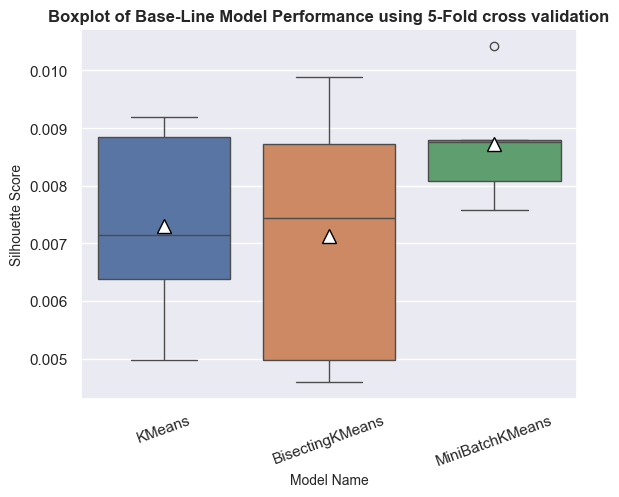

In [17]:
# Plot the results
sns.boxplot(x='model_name', y='silhouette_score', hue='model_name',
            data=cross_validation_df, showmeans=True,
            palette=sns.color_palette()[:baseline_models.__len__()],
            # Reference: https://matplotlib.org/stable/api/markers_api.html
            meanprops={"marker":"^","markerfacecolor":"white", 
                       "markeredgecolor":"black", "markersize":"10"}
            )
plt.title(f"Boxplot of Base-Line Model Performance using {K_FOLDS}-Fold cross validation",
          fontsize=12, fontweight="bold")
plt.xlabel("Model Name", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.xticks(rotation=20)
plt.show();

📑 Summarize the results

In [18]:
# Summarize the results
baseline_results = \
    cross_validation_df.groupby('model_name')["silhouette_score"]\
        .agg(['mean', 'std']).sort_values(by='mean', ascending=False)

# Add metric names
baseline_results.columns.name = "silhouette_score"

baseline_results

silhouette_score,mean,std
model_name,,
MiniBatchKMeans,0.008726,0.001073
KMeans,0.007307,0.001749
BisectingKMeans,0.007125,0.002312


> <u>**Nhận xét**</u>: `MiniBatchKMeans` là "baseline model" chạy tốt nhất trên tập dữ liệu `train_data`. Ở bước tiếp theo, ta cần thực hiện "Hyper-parameter Tuning" để giúp các model tạo ra kết quả tốt hơn nữa.

## Hyper-parameter Tuning

### 📈 Getting the optimal number of clusters

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# # Reference: https://www.geeksforgeeks.org/determining-the-number-of-clusters-in-data-mining/
# # Determining the maximum number of clusters using the simple method
# limit = int((clean_df.shape[0]//2)**0.5)
# K = list(range(limit, limit-10, -1))

K = list(range(3, 25, 1))
data = vectorizer.transform(train_data)

# wcss - within cluster sum of squared distances
wcss_df = pd.DataFrame(columns=['n_clusters', 'model_name', 'wcss'])
models = {
    'KMeans': KMeans,
    'BisectingKMeans': BisectingKMeans,
    'MiniBatchKMeans': MiniBatchKMeans,
}

with tqdm.tqdm(total=len(K)) as pbar:
    pbar.set_description("Elbow Method is in progress...")
    for n_clusters in K:
        for model_name, model_prototype in models.items():
            model = model_prototype(n_clusters=n_clusters, random_state=SEED,
                                    init='k-means++', n_init=1)
            model.fit(data)
            wcss_df.loc[len(wcss_df)] = [n_clusters, model_name, model.inertia_]
        
        pbar.update(1)

# ~ 8min

Elbow Method is in progress...: 100%|██████████| 22/22 [02:47<00:00,  7.62s/it]


🎨 Visualize the results

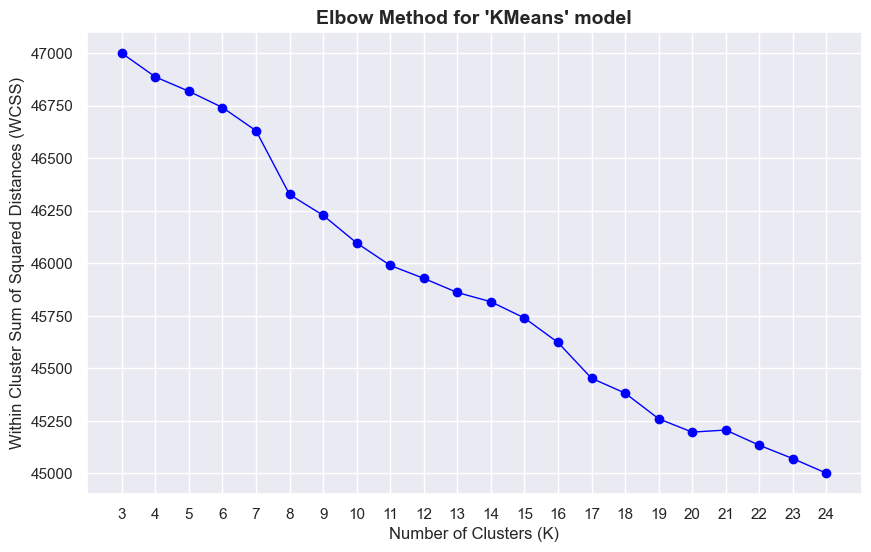

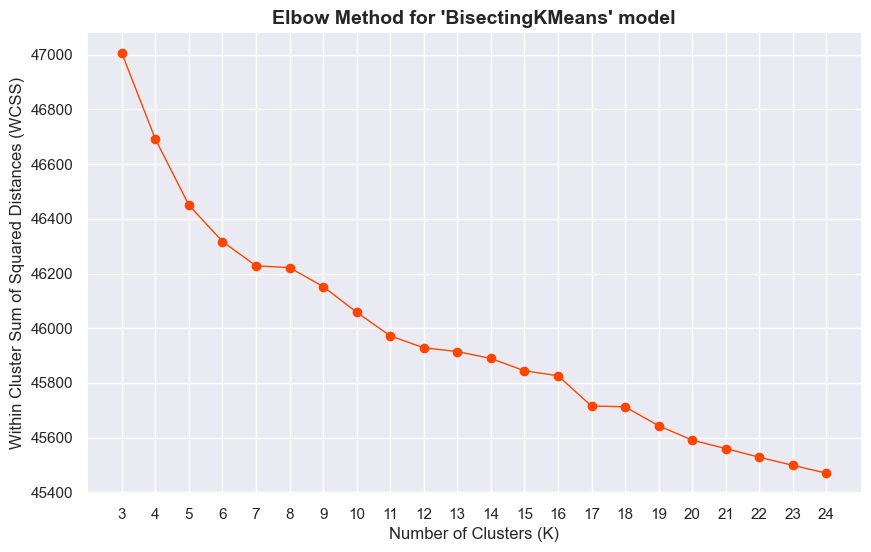

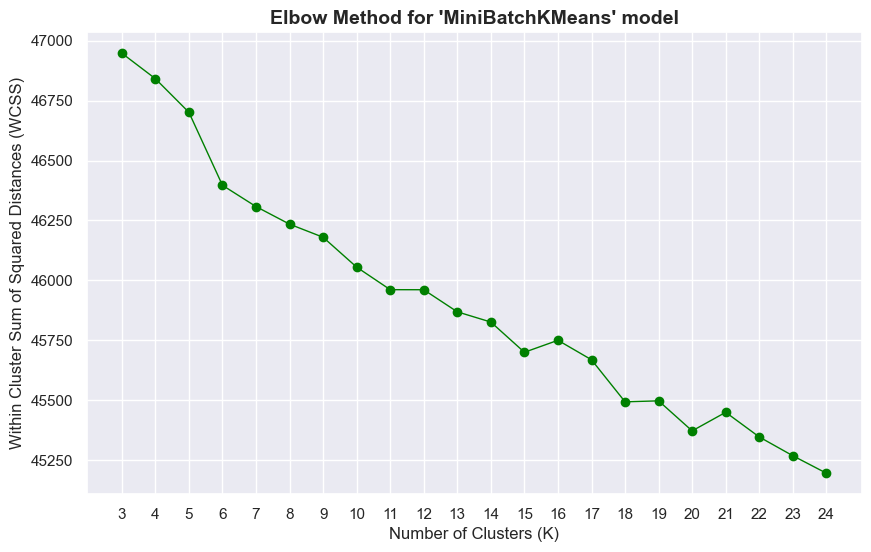

In [20]:
colors = ['blue', 'orangered', 'green']
for i, model_name in enumerate(models.keys()):
    ax = wcss_df.query(f"model_name == '{model_name}'").plot.line(
        x='n_clusters', y='wcss', figsize=(10, 6),
        marker='o', color=colors[i], linewidth=1,
        legend=False,
    )
    ax.set_xticks(K)
    ax.set_title(f"Elbow Method for \'{model_name}\' model",
                 fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.set_xlabel("Number of Clusters (K)")
    ax.set_ylabel("Within Cluster Sum of Squared Distances (WCSS)")
    

> <u>**Nhận xét**</u>: Quan sát các biểu đồ trên, ta thấy rằng các tham số `n_clusters` nên được sử dụng để tinh chỉnh từng mô hình là: 
> - KMeans: `[8, 11, 17, 19]`
> - BisectingKMeans: `[7, 11, 15, 17]`
> - MiniBatchKMeans: `[6, 11, 14, 18]`

### For the other hyper-parameters

In [21]:
def _hyperParameters_tuning(model: sklearn.cluster, 
                            hyperParams_grid: Dict[str, List]) -> Dict[str, Any]:
    best_score: float = 0.0
    best_hyperParams: Dict[str, Any] = None

    # Get all combinations
    all_combinations = list(itertools.product(*hyperParams_grid.values()))

    # Create a list of dictionaries for each combination
    hyperParams_combinations = [dict(zip(hyperParams_grid.keys(), combination)) 
                                for combination in all_combinations]

    # Convert text to numerical data using TF-IDF
    _data_to_train = vectorizer.transform(train_data)
    _data_to_valid = vectorizer.transform(valid_data)

    print(f"========== Fine-tuning '{model.__class__.__name__}' on total {len(hyperParams_combinations)} hyper-parameter combinations ==========")
    for i, hyperParams in enumerate(hyperParams_combinations,start=1):
        # Set hyperparameters
        model.set_params(**hyperParams)
        
        # Fit the model to the training data
        print(f"Fitting on combination {str(i).rjust(2)}...", end="")
        model.fit(_data_to_train)
        
        # Evaluate the model on the validation data
        print(f" -> Evaluating...", end="")
        pred = model.predict(_data_to_valid)
        score = metrics.silhouette_score(_data_to_valid, pred, metric='euclidean')

        if score > best_score:
            print(f" -> Get new best-score: {score:.6f}, updating best-hyper-parameters...")
            best_score = score
            best_hyperParams = hyperParams
        else:
            print(f" -> Best-score remains: {best_score:.6f}")
            
    return best_hyperParams


#### `KMeans`

In [22]:
kmeans_best_hyperParams = _hyperParameters_tuning(KMeans(), {
    'verbose': [0],
    'random_state': [SEED],
    'max_iter': [300],
    'n_init': [3],
    'tol': [1e-6],
    
    'init': ['k-means++', 'random'],
    'algorithm': ['lloyd', 'elkan'],
    'n_clusters': [8, 11, 17, 19],
}) # ~ 10min

========== Fine-tuning 'KMeans' on total 16 hyper-parameter combinations ==========
Fitting on combination  1... -> Evaluating... -> Get new best-score: 0.009938, updating best-hyper-parameters...
Fitting on combination  2... -> Evaluating... -> Get new best-score: 0.010318, updating best-hyper-parameters...
Fitting on combination  3... -> Evaluating... -> Get new best-score: 0.015240, updating best-hyper-parameters...
Fitting on combination  4... -> Evaluating... -> Get new best-score: 0.016935, updating best-hyper-parameters...
Fitting on combination  5... -> Evaluating... -> Best-score remains: 0.016935
Fitting on combination  6... -> Evaluating... -> Best-score remains: 0.016935
Fitting on combination  7... -> Evaluating... -> Best-score remains: 0.016935
Fitting on combination  8... -> Evaluating... -> Best-score remains: 0.016935
Fitting on combination  9... -> Evaluating... -> Best-score remains: 0.016935
Fitting on combination 10... -> Evaluating... -> Best-score remains: 0.016

In [23]:
# TEST
kmeans_best_hyperParams

{'verbose': 0,
 'random_state': 2023,
 'max_iter': 300,
 'n_init': 3,
 'tol': 1e-06,
 'init': 'k-means++',
 'algorithm': 'lloyd',
 'n_clusters': 19}

#### `BisectingKMeans`

In [24]:
bisecting_kmeans_best_hyperParams = \
    _hyperParameters_tuning(BisectingKMeans(), {
        'verbose': [0],
        'random_state': [SEED],
        'max_iter': [300],
        'n_init': [3],
        'tol': [1e-6],
        
        'init': ['k-means++', 'random'],
        'algorithm': ['lloyd', 'elkan'],
        'bisecting_strategy': ['biggest_inertia', 'largest_cluster'],
        'n_clusters': [7, 11, 15, 17],
    }) # ~ 22min

========== Fine-tuning 'BisectingKMeans' on total 32 hyper-parameter combinations ==========
Fitting on combination  1... -> Evaluating... -> Get new best-score: 0.009670, updating best-hyper-parameters...
Fitting on combination  2... -> Evaluating... -> Get new best-score: 0.011994, updating best-hyper-parameters...
Fitting on combination  3... -> Evaluating... -> Get new best-score: 0.012718, updating best-hyper-parameters...
Fitting on combination  4... -> Evaluating... -> Best-score remains: 0.012718
Fitting on combination  5... -> Evaluating... -> Best-score remains: 0.012718
Fitting on combination  6... -> Evaluating... -> Best-score remains: 0.012718
Fitting on combination  7... -> Evaluating... -> Best-score remains: 0.012718
Fitting on combination  8... -> Evaluating... -> Best-score remains: 0.012718
Fitting on combination  9... -> Evaluating... -> Best-score remains: 0.012718
Fitting on combination 10... -> Evaluating... -> Best-score remains: 0.012718
Fitting on combination

In [25]:
# TEST
bisecting_kmeans_best_hyperParams

{'verbose': 0,
 'random_state': 2023,
 'max_iter': 300,
 'n_init': 3,
 'tol': 1e-06,
 'init': 'random',
 'algorithm': 'lloyd',
 'bisecting_strategy': 'biggest_inertia',
 'n_clusters': 15}

#### `MiniBatchKMeans`

In [26]:
minibatch_kmeans_best_hyperParams = \
    _hyperParameters_tuning(MiniBatchKMeans(), {
        'verbose': [0],
        'random_state': [SEED],
        'max_iter': [300],
        'n_init': [10],
        'tol': [0.0],
        'init_size': [None],
        'batch_size': [1024],
        
        'init': ['k-means++', 'random'],
        'max_no_improvement': [10, 20],
        'reassignment_ratio': [0.01, 0.001],
        'n_clusters': [6, 11, 14, 18],
        
    }) # ~ 4min

========== Fine-tuning 'MiniBatchKMeans' on total 32 hyper-parameter combinations ==========
Fitting on combination  1... -> Evaluating... -> Get new best-score: 0.007332, updating best-hyper-parameters...
Fitting on combination  2... -> Evaluating... -> Get new best-score: 0.011916, updating best-hyper-parameters...
Fitting on combination  3... -> Evaluating... -> Best-score remains: 0.011916
Fitting on combination  4... -> Evaluating... -> Get new best-score: 0.012564, updating best-hyper-parameters...
Fitting on combination  5... -> Evaluating... -> Best-score remains: 0.012564
Fitting on combination  6... -> Evaluating... -> Best-score remains: 0.012564
Fitting on combination  7... -> Evaluating... -> Get new best-score: 0.014094, updating best-hyper-parameters...
Fitting on combination  8... -> Evaluating... -> Get new best-score: 0.015489, updating best-hyper-parameters...
Fitting on combination  9... -> Evaluating... -> Best-score remains: 0.015489
Fitting on combination 10... -

In [27]:
# TEST
minibatch_kmeans_best_hyperParams

{'verbose': 0,
 'random_state': 2023,
 'max_iter': 300,
 'n_init': 10,
 'tol': 0.0,
 'init_size': None,
 'batch_size': 1024,
 'init': 'k-means++',
 'max_no_improvement': 20,
 'reassignment_ratio': 0.001,
 'n_clusters': 18}

## Training models and evaluation

Create models with the best hyper-parameters and save them for future use

In [28]:
# Get the best model
best_kmeans_model = KMeans(**kmeans_best_hyperParams)
best_bisecting_kmeans_model = BisectingKMeans(**bisecting_kmeans_best_hyperParams)
best_minibatch_kmeans_model = MiniBatchKMeans(**minibatch_kmeans_best_hyperParams)

best_models = {
    'best_kmeans_model': best_kmeans_model,
    'best_bisecting_kmeans_model': best_bisecting_kmeans_model,
    'best_minibatch_kmeans_model': best_minibatch_kmeans_model,
}

# Save the best model for later use
# Reference: https://stackoverflow.com/questions/54879434/how-to-use-pickle-to-save-sklearn-model
for model_name, model in best_models.items():
    with open(f"../data/models/{model_name}.pkl", "wb") as f:
        pickle.dump(model, f)

Load models if needed

In [29]:
best_models_lst = ['best_kmeans_model', 'best_bisecting_kmeans_model', 'best_minibatch_kmeans_model']
best_models = {}
# Load model if needed
for model_name in best_models_lst:
    with open(f"../data/models/{model_name}.pkl", "rb") as f:
        best_models[model_name] = pickle.load(f)
        print(f"[LOG] Loaded model '{model_name}'")
        print(best_models[model_name].get_params(),end="\n\n")

print(f">> Total number of models: {best_models.__len__()}")

[LOG] Loaded model 'best_kmeans_model'
{'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 19, 'n_init': 3, 'random_state': 2023, 'tol': 1e-06, 'verbose': 0}

[LOG] Loaded model 'best_bisecting_kmeans_model'
{'algorithm': 'lloyd', 'bisecting_strategy': 'biggest_inertia', 'copy_x': True, 'init': 'random', 'max_iter': 300, 'n_clusters': 15, 'n_init': 3, 'random_state': 2023, 'tol': 1e-06, 'verbose': 0}

[LOG] Loaded model 'best_minibatch_kmeans_model'
{'batch_size': 1024, 'compute_labels': True, 'init': 'k-means++', 'init_size': None, 'max_iter': 300, 'max_no_improvement': 20, 'n_clusters': 18, 'n_init': 10, 'random_state': 2023, 'reassignment_ratio': 0.001, 'tol': 0.0, 'verbose': 0}

>> Total number of models: 3


(Re-)Train models on (`training + validating` set) and evaluate them on `testing` set

In [30]:
model_name_logs = {
    'best_kmeans_model': '================ best_kmeans_model ================',
    'best_bisecting_kmeans_model': '=========== best_bisecting_kmeans_model ===========',
    'best_minibatch_kmeans_model': '=========== best_minibatch_kmeans_model ===========',
}
model_prototypes = {
    'best_kmeans_model': KMeans,
    'best_bisecting_kmeans_model': BisectingKMeans,
    'best_minibatch_kmeans_model': MiniBatchKMeans,
}

# Store the result to dateframe
# history_df = pd.DataFrame(columns=["model_name", "n_init", "score"])
history_df = pd.DataFrame(columns=["model_name", "max_iter", 
                                   "training_score", "testing_score"])

# Combine train and validation data
final_train_data = pd.concat([train_data, valid_data], axis=0)

# Convert text to numerical data using TF-IDF
data_to_train = vectorizer.transform(final_train_data)
data_to_test = vectorizer.transform(test_data)

MAX_ITERS = range(2,29,2)
for model_name, model in best_models.items():
    if model_name not in model_name_logs.keys():
        continue
    print(f"{model_name_logs[model_name]}\n")
    for max_iter in MAX_ITERS:
        # Create a new model using the best hyper-parameters
        model = model_prototypes[model_name]\
                    (**best_models[model_name].get_params())
        
        # Update parameters of new model
        model.random_state = SEED
        model.n_init = 1
        model.max_iter = max_iter
    
        # Fit each model on `data_to_train`
        model.fit(data_to_train)
        training_score = model.inertia_
        
        # Evalute model on `data_to_test`
        pred = model.predict(data_to_test)
        testing_score = metrics.silhouette_score(data_to_test, pred)
        
        # LOG
        # print(f"`max_iter` = {str(max_iter).rjust(2)} -> score: {score}")
        print(f"`max_iter` = {max_iter}\n-------------------------------")
        print(f"Training score: {training_score}")
        print(f"Testing score: {testing_score}", end="\n\n")
    
        # Update history
        history_df.loc[len(history_df)] \
            = [model_name, max_iter, training_score, testing_score]

# ~20min

================ best_kmeans_model ================

`max_iter` = 2
-------------------------------
Training score: 50933.3359375
Testing score: 0.013630102388560772

`max_iter` = 4
-------------------------------
Training score: 50774.8046875
Testing score: 0.015171290375292301

`max_iter` = 6
-------------------------------
Training score: 50745.421875
Testing score: 0.015204020775854588

`max_iter` = 8
-------------------------------
Training score: 50740.515625
Testing score: 0.015063632279634476

`max_iter` = 10
-------------------------------
Training score: 50728.99609375
Testing score: 0.015062756836414337

`max_iter` = 12
-------------------------------
Training score: 50728.859375
Testing score: 0.015054654330015182

`max_iter` = 14
-------------------------------
Training score: 50728.8359375
Testing score: 0.01505267433822155

`max_iter` = 16
-------------------------------
Training score: 50728.8203125
Testing score: 0.01505267433822155

`max_iter` = 18
-------------------

In [31]:
# Save the result
history_df.to_csv("../data/interim/history.csv", index=False)
history_df = pd.read_csv("../data/interim/history.csv")

## Results analysis

🎨 Visualize the results (separately)

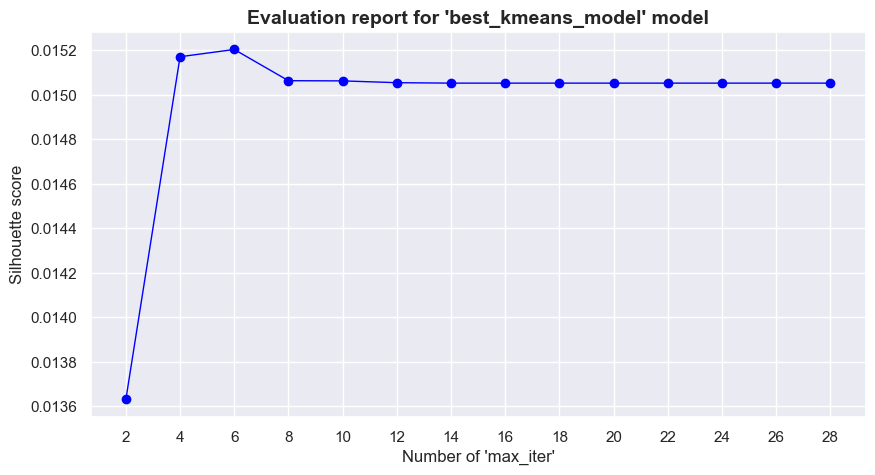

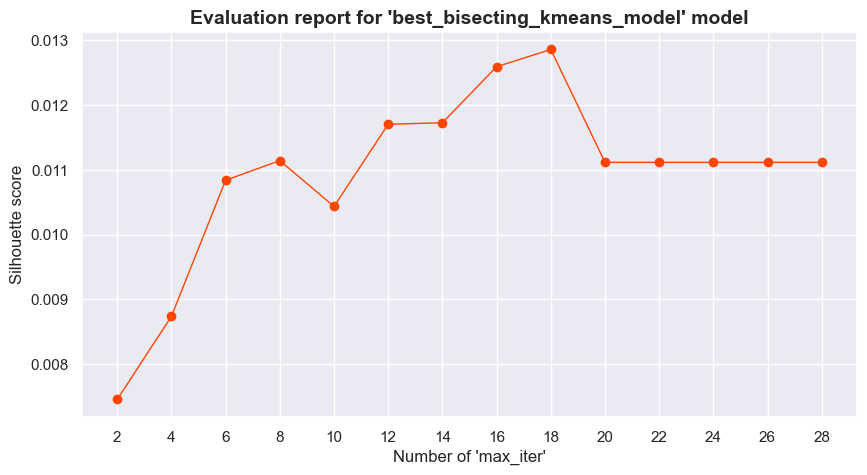

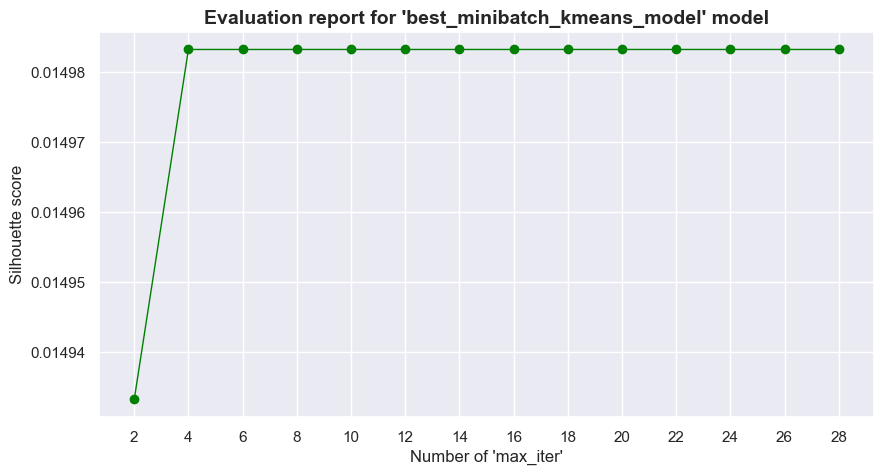

In [32]:
# Visualize the results separately
MAX_ITERS = range(2,29,2)
colors = ['blue', 'orangered', 'green']
for i, model_name in enumerate(best_models.keys()):
    ax = history_df.query(f"model_name == '{model_name}'").plot.line(
        x='max_iter', y='testing_score', figsize=(10, 5),
        marker='o', color=colors[i], linewidth=1,
        legend=False,
    )
    ax.set_xticks(MAX_ITERS)
    ax.set_title(f"Evaluation report for \'{model_name}\' model",
                 fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.set_xlabel("Number of \'max_iter\'")
    ax.set_ylabel("Silhouette score")

📈 Summarize the results

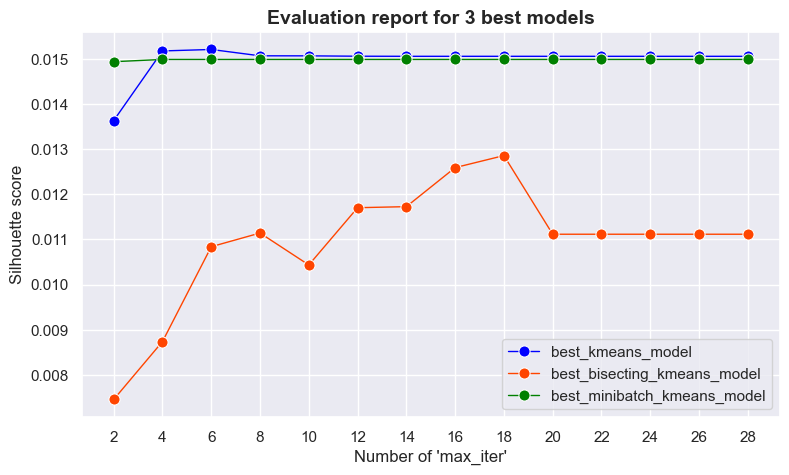

In [33]:
# Visualize the results together
colors = ['blue', 'orangered', 'green']
fig, ax = plt.subplots(figsize=(9,5))
for i, model_name in enumerate(best_models.keys()):
    # Get result of each model
    result = history_df.query(f"model_name == '{model_name}'")
    
    # Visualize the result using line chart
    sns.lineplot(x='max_iter', y='testing_score', data=result,
                 marker='o', color=colors[i], linewidth=1,
                 label=model_name, ax=ax, markersize=8)

# Set title and labels, xticks
plt.title(f"Evaluation report for {best_models.__len__()} best models",
          fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Number of \'max_iter\'")
plt.ylabel("Silhouette score")
plt.xticks(MAX_ITERS)
plt.legend(loc='best')

plt.show();

In [34]:
# Summarize the results
eval_results = history_df.query(f"max_iter == {max(MAX_ITERS)}")
eval_results[['model_name', 'testing_score']]\
    .sort_values(by='testing_score', ascending=False)\
        .set_index('model_name')\
            .rename(columns={'testing_score': 'convergent_silhouette_score'})

,convergent_silhouette_score
model_name,
best_kmeans_model,0.015053
best_minibatch_kmeans_model,0.014983
best_bisecting_kmeans_model,0.011113


## Conclusion

Như vậy, `best_kmeans_model` là mô hình hoạt động tốt nhất trên tập dữ liệu của chúng ta. Do đó, ta sẽ tận dụng mô hình này để giải quyết bài toán đã đề ra ban đầu.

## Clustering all video titles

Define `my_best_model` and optimize it

In [35]:
# Define the best model
best_model_name = 'best_kmeans_model'
my_best_model = None
with open(f"../data/models/{best_model_name}.pkl", "rb") as f:
    my_best_model = pickle.load(f)
    # print(f"[LOG] Loaded model '{best_model_name}'")

# Display the best model
my_best_model

KMeans(n_clusters=19, n_init=3, random_state=2023, tol=1e-06)

In [36]:
# # Optimize the model
# my_best_model.n_init = 3
# my_best_model.max_iter = 10
# my_best_model.n_clusters = 24

In [37]:
# TEST
my_best_model.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 19,
 'n_init': 3,
 'random_state': 2023,
 'tol': 1e-06,
 'verbose': 0}

Train `my_best_model` on all video data in dataset

In [38]:
# Combine train, validation and test data
all_video_data = pd.concat((train_data, valid_data, test_data), axis=0)

# Convert text to numerical data using TF-IDF
data = vectorizer.transform(all_video_data)

# Train the model on all data
my_best_model.fit(data)

# Get the labels (cluster_id) of all data
labels = my_best_model.predict(data)
# ~ 4min

In [39]:
# Check the number of min videos in each cluster
# for n in range(3, 40):
#     my_best_model.n_clusters = n
#     my_best_model.fit(data)
#     labels = my_best_model.predict(data)
#     print(n, pd.Series(labels).value_counts().min())

Use prediction result to assign `cluster_id` to each video in dataset

In [40]:
video_cluster_df = pd.DataFrame({
    'index': all_video_data.index,
    'cluster_id': labels
})

In [41]:
merged_df = pd.merge(left=video_cluster_df, right=clean_df, 
                     left_on='index', right_index=True)

Drop unnecessary columns

In [42]:
# Drop unnecessary columns
unnecessary_cols = ['index', 'publishedAt.hour', 'publishedAt.day', 
                    'publishedAt.year', 'publishedAt.month', 'hour', 'day', 
                    'day_of_week', 'month', 'year', 'definition', 'caption',
                    'definition_score', 'caption_score',
                    'like_score', 'comment_score', 'description']
for col in unnecessary_cols:
    if col in merged_df.columns:
        merged_df.drop(columns=col, inplace=True)

In [43]:
# TEST
merged_df.sample(3)

,cluster_id,video_id,channelTitle,title,tags,publishedAt,viewCount,likeCount,commentCount,duration,score,clean_title
34229,0,r5uxntl_hWg,MLOps.community,"'Git for Data' - Who, What, How and Why? // Lu...",git for data science|git for data scientists|g...,2021-02-19 18:43:42+00:00,828,28,2,3464,682.359059,git data luke feeney gavin mendelgleason mlops...
53133,0,owLFUyJH_2k,itversity,Cloud and Data Engineering Bootcamp - Fall'19 ...,(notag),2019-08-15 16:32:41+00:00,1169,16,0,1599,963.320864,cloud data engineering bootcamp fall overview
33684,1,Iw2H3WT-c1s,Great Learning,Matplotlib Python Tutorial | Matplotlib Tutori...,Great Learning|Great Lakes|python tutorial|dat...,2020-11-16 12:30:51+00:00,25122,592,34,2917,20700.604013,matplotlib python tutorial matplotlib tutorial...


In [44]:
# Save final data for later use
merged_df.to_csv('../data/processed/video_data_clustered.csv', index=False)

# Save the model for later use
with open("../data/models/my_best_model.pkl", "wb") as f:
    pickle.dump(my_best_model, f)

## Prediction

Assign `cluster_id` for new text data

In [52]:
# Assuming 'new_data' is a list of new video titles
new_data = ["Tech news and updates",
            "Learn Python in fast and easy way",
            "Machine learning explained in 5 minutes",
            "How to use tableau and Power BI for data visualization",
            "Top 10 programming languages in 2021",
            "What is the difference between data science vs data analyst vs data engineer VS Business Analyst",
            "How to become a Data Analyst",
            ]

new_data = pd.Series(new_data)
text_values = new_data.apply(preprocess_text)

# Transform the preprocessed new data into TF-IDF features using the same vectorizer
new_tfidf_matrix = vectorizer.transform(text_values)

# Use the trained k-means model to predict cluster labels for the new data
pred_labels = my_best_model.predict(new_tfidf_matrix)

##### Recommend top `n` video titles in the same cluster

In [53]:
# Return top `n` video titles in the same cluster
def _recommend_top_n_videos(cluster_id: int, top_n: int = 10) -> pd.DataFrame:
    metric_to_sort: str = 'score'
    threshold_for_shuffle: int = 10
    
    # Define a dataframe to store the recommended videos
    recommended_videos = pd.DataFrame(columns=['channelTitle', 'title'])
    
    # Define a set to store the channels that have been recommended
    set_of_channels = set()
    
    # Get all videos in the same cluster then sort them by their views
    video_in_cluster = merged_df.query(f"cluster_id == {cluster_id}")\
                        .sort_values(by=metric_to_sort, ascending=False)

    # Iterate through each video in the cluster
    def _get_n_videos_from_different_channel(video_df: pd.DataFrame, 
                                             n_videos: int) -> None:
        n_completed = 0
        for i, video in video_df.iterrows():
            channelTitle = video['channelTitle']
            videoTitle = video['title']
            
            # If the channel has already been recommended, skip it
            if channelTitle in set_of_channels:
                continue
            
            # Otherwise, add it to the list of recommended channels
            recommended_videos.loc[len(recommended_videos)] = [channelTitle, videoTitle]
            
            # Add the channel to the set
            set_of_channels.add(channelTitle)
            
            # If we have enough channels, stop
            n_completed += 1
            if n_completed >= n_videos:
                return
    
    if top_n >= threshold_for_shuffle:
        # Get first half of the videos
        first_half  = top_n // 2
        _get_n_videos_from_different_channel(video_df=video_in_cluster, 
                                             n_videos=first_half)
        # Get second half of the videos
        video_in_cluster = video_in_cluster.sample(frac=1)
        second_half = top_n - first_half
        _get_n_videos_from_different_channel(video_df=video_in_cluster, 
                                             n_videos=second_half)
    else:
        _get_n_videos_from_different_channel(video_df=video_in_cluster, 
                                             n_videos=top_n)
    
    return recommended_videos

Show some results

In [54]:
# Display the results
for i, title in enumerate(new_data):
    recommended_videos = _recommend_top_n_videos(pred_labels[i], top_n=10)
    print(f"Recommended videos for '{title}':")
    print(recommended_videos)
    print("--------------------------------------\n")

Recommended videos for 'Tech news and updates':
          channelTitle                                              title
0      Google DeepMind  AlphaGo - The Movie | Full award-winning docum...
1            Joma Tech  a day in the life of an engineer working from ...
2          3Blue1Brown  But what is a Fourier series?  From heat flow ...
3          Lex Fridman  Jordan Peterson: Life, Death, Power, Fame, and...
4    Two Minute Papers  OpenAI Plays Hide and Seek…and Breaks The Game! 🤖
5           Databricks  Scaling AutoML-Driven Anomaly Detection With L...
6             Jay Feng  How to answer the cross functional interview q...
7            itversity            Apache Oozie - Execute mapreduce action
8  Unfold Data Science  Hive Query Language Tutorial |  Hive query lan...
9       Yannic Kilcher  On the Measure of Intelligence by François Cho...
--------------------------------------

Recommended videos for 'Learn Python in fast and easy way':
          channelTitle                

##### Recommend top `n` tags in the same cluster

In [55]:
def _recommend_top_n_tags(cluster_id: int, top_n: int = 10) -> np.ndarray:
    tags_in_cluster = merged_df.query(f"cluster_id == {cluster_id}")
    tags_in_cluster = \
        tags_in_cluster.sort_values(by='viewCount', ascending=False,)\
            ['tags'].head(4*top_n)

    # Create a dataframe to store the one-hot encoding of tags
    one_hot_df = tags_in_cluster.str.get_dummies(sep='|')
    if "(notag)" in one_hot_df.columns:
        one_hot_df = one_hot_df.drop("(notag)",axis=1)
    # Sum the one-hot encoding of tags
    all_tags = one_hot_df.sum().sort_values(ascending=False).head(4*top_n)

    # Preprocess all tags
    preprocessed_tags = pd.Series(all_tags.index).apply(preprocess_text)
    preprocessed_tags = preprocessed_tags[preprocessed_tags != ""]
    
    # Get only unique tags
    unique_tags = pd.unique(preprocessed_tags)
    np.random.shuffle(unique_tags)
    return unique_tags

Show some results

In [56]:
# Display the results
for i, title in enumerate(new_data):
    recommended_tags = _recommend_top_n_tags(pred_labels[i], top_n=10)
    print(f"Recommended tags for '{title}':")
    print("\"" + "\", \"".join(recommended_tags.tolist()) + "\"")
    print("--------------------------------------\n")

Recommended tags for 'Tech news and updates':
"ai", "brown blue", "math", "artificial intelligence podcast", "lex jre", "laser eyes", "agi", "brownblue", "mathematics", "vlog", "lex podcast", "pi", "three blue one brown", "fourier series", "ai podcast", "physics", "blue brown", "life", "geometry", "one", "brown", "fourier", "joma", "lex fridman", "lex ai", "mit ai", "lex mit", "bitcoin", "artificial intelligence", "three", "government", "calculus", "blue", "software engineer", "consciousness", "bb", "evolution", "elon musk", "three brown one blue"
--------------------------------------

Recommended tags for 'Learn Python in fast and easy way':
"classes", "python projects", "tech tim", "python absolute beginners", "absolute beginners", "python oop", "attributes", "object oriented programming", "class", "python data types", "python tutorial", "getting started python", "python full course", "python classes", "python data science tutorial", "python objects", "python programming language", 

## Conclusion

##### 1. In Vietnamese

- Chỉ với những nguồn tài nguyên ít ỏi, ta đã thành công xây dựng một hệ thống đề xuất video và tags đơn giản, giải quyết được bài toán mà ta đã đề ra ban đầu.

- Tuy nhiên, do những hạn chế nhất định về phần cứng (chủ yếu là `RAM`) đã làm cho từ điển của chúng ta có sức chứa chưa đủ lớn để đáp ứng nhu cầu sử dụng trong thực tế. Kết quả là làm cho model (hệ thống đề xuất) mà chúng ta xây dựng còn nhiều sai sót.

- Những điều có thể cải thiện trong tương lai:
    - Nếu có được nguồn tài nguyên máy tính tốt hơn thì ta có thể mở rộng phạm vi của thư viện, giúp nó chứa được nhiều từ hơn. Khi nhận được một đoạn văn do người dùng nhập vào thì ta sẽ có thêm nhiều thông tin, giúp model phân loại chính xác hơn hay nói cách khác là giúp hệ thống đề xuất của chúng ta hoạt động tốt hơn.
    
    - Ngoài ra, ta có thể tìm hiểu thêm các thuật toán đánh giá điểm số cho một video, hiện tại ta chỉ sử dụng các số liệu thô một cách đơn giản. Việc có được một cách đánh giá "tổng quát hơn" sẽ cải thiện hiệu suất hoạt động của mô hình lên đáng kể. Giúp kết quả dự đoán gần đúng với mong muốn của người dùng hơn.

> Ví dụ: 
> - Chẳng hạn như vào cuối tuần hoặc vào buổi tối thì ta nên đề xuất các video có nội dung "nhẹ nhàng hơn" và có thời gian ngắn hơn để người dùng có thể xem trước khi nghỉ ngơi. Việc đề xuất một video dài 10 tiếng đồng hồ hoặc có nội dung quá nặng về mặt học thuật sẽ làm người dùng có phần nản chí và khả năng cao là họ sẽ không xem video đó. Trong trường hợp đó, ta có thể đánh giá là mô hình đang hoạt động chưa tốt vì nó làm chúng ta đánh mất một lượng lớn khách hàng tiềm năng. v.v.


##### 2. In English

- With only limited resources, we have successfully built a simple video and tag recommendation system, solving the problem we initially posed.

- However, due to certain hardware limitations (mainly `RAM`), our dictionary's capacity is not large enough to meet actual usage needs. As a result, the model (recommended system) we built has many errors.

- Things that can be improved in the future:
    - If we have better computer resources, we can expand the scope of the library, helping it contain more words. When we receive a paragraph entered by the user, we will have more information, helping the model classify more accurately, or in other words, helping our recommendation system work better.
    
    - In addition, we can learn more algorithms to evaluate scores for a video, currently we only use raw data in a simple way. Having a "more general" assessment will improve model performance significantly. Helps prediction results more closely match the user's wishes.

___